# Models approach

We are going to try 2 different models to solve this problem and see which one performs better. The models are:
- Neural Network
- Bernouilli Naive Bayes

For both models we are going to see what features tend to be more important, so firstly we are going to create a model using all features and then observe the feature importance.

Once we choose our features, it is important to see if outliners are affecting our model. Normally we would remove because it can affect the model performance.

Furthermore, we are going to take into account 2 approaches to deal with the imbalanced dataset as we have seen in the EDA:
- Not doing anything
- Undersampling

## Imports

In [14]:
import mlflow
import tempfile
import livelossplot
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import keras_tuner as kt
from mlflow.models import infer_signature
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, f1_score, classification_report, confusion_matrix,ConfusionMatrixDisplay
from sklearn.feature_selection import mutual_info_classif
from sklearn import metrics
from sklearn.preprocessing import label_binarize
from sklearn.utils import class_weight,resample
from keras import models
from keras.layers import Dense, Dropout, BatchNormalization
from keras.utils import to_categorical
from keras.optimizers import Adam
from keras.metrics import AUC
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from imblearn.over_sampling import SMOTE
from time import sleep

## Loading the data

In [15]:
df_vaccine = pd.read_csv('../datasets_procesados/training_set_processed.csv')
df_labels = pd.read_csv('../datasets_originales/training_set_labels.csv')
df_test = pd.read_csv('../datasets_originales/test_set_features.csv')

df_vaccine.head()

,respondent_id,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,...,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,...,2.0,1.0,0.0,1.0,8.0,2.0,0.0,0.0,11.0,12.0
1,1.0,4.0,3.0,0.0,2.0,0.0,2.0,0.0,2.0,2.0,...,2.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,13.0,20.0
2,2.0,1.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,9.0,0.0,3.0,0.0,15.0,22.0
3,3.0,1.0,1.0,0.0,2.0,0.0,2.0,2.0,0.0,0.0,...,2.0,1.0,1.0,1.0,5.0,1.0,0.0,0.0,11.0,12.0
4,4.0,3.0,1.0,0.0,2.0,0.0,2.0,2.0,0.0,2.0,...,0.0,0.0,0.0,0.0,9.0,0.0,2.0,0.0,19.0,5.0


## Definition of the split

In [16]:
features = df_vaccine.columns[:-2]
X_train = df_vaccine[features]
y_h1n1_train = df_labels['h1n1_vaccine']
y_seasonal_train = df_labels['seasonal_vaccine']

# Perform the split for initial evaluation of the models
X_train_split, X_val_split, y_h1n1_train_split, y_h1n1_val_split = train_test_split(X_train, y_h1n1_train, test_size=0.2, random_state=42)
_, _, y_seasonal_train_split, y_seasonal_val_split = train_test_split(X_train, y_seasonal_train, test_size=0.2, random_state=42)

## Class Approach: Not doing anything

### Global variables

In [17]:
CV = 5
K_FEATURES = 16

### Feature Importance

To see the feature importance we have different approaches.
- We could use a Random Forest Classifier to see the feature importance
- Mutual Information: estimate the mutual information for a discrete target variable. Measures the dependency between the variables according to the amount of shared information. The higher the value, the more important the feature is.
- Correlation matrix: we can see the correlation between the features and the target variable. The higher the correlation, the more important the feature is.


##### Random Forest feature selection

In [18]:
# Create Random Forest Classifier to see the importance of the features from h1n1_vaccine
tree = RandomForestClassifier()
tree.fit(X_train, y_h1n1_train)
importances = tree.feature_importances_
pd.DataFrame({'Attributes': features ,
              'Feature importance': importances}).sort_values('Feature importance', ascending=False).head(K_FEATURES)

,Attributes,Feature importance
10,doctor_recc_h1n1,0.105744
0,respondent_id,0.083611
17,opinion_h1n1_risk,0.073366
15,health_insurance,0.060904
16,opinion_h1n1_vacc_effective,0.056457
30,hhs_geo_region,0.051064
20,opinion_seas_risk,0.040325
22,age_group,0.034828
19,opinion_seas_vacc_effective,0.029313
18,opinion_h1n1_sick_from_vacc,0.029202


In [19]:
# Create Random Forest Classifier to see the importance of the features from seasonal_vaccine
tree = RandomForestClassifier()
tree.fit(X_train, y_seasonal_train)
importances = tree.feature_importances_
pd.DataFrame({'Attributes': features,
              'Feature importance': importances}).sort_values('Feature importance', ascending=False).head(K_FEATURES)

,Attributes,Feature importance
19,opinion_seas_vacc_effective,0.092746
20,opinion_seas_risk,0.090341
0,respondent_id,0.080114
11,doctor_recc_seasonal,0.078529
22,age_group,0.065103
30,hhs_geo_region,0.049354
17,opinion_h1n1_risk,0.035398
16,opinion_h1n1_vacc_effective,0.032667
21,opinion_seas_sick_from_vacc,0.030235
23,education,0.029317


Using the same approach for both target, we can state that features have not the same importance for both targets.

##### Mutual Information feature selection

In [20]:
# Select the best features with mutual information for h1n1_vaccine
mutual_info = mutual_info_classif(X_train, y_h1n1_train,random_state=42)
print('H1N1 VACCINE - Mutual information')
mutual_info_df = pd.DataFrame({'Attributes': features,
              'Mutual information': mutual_info}).sort_values('Mutual information', ascending=False).head(K_FEATURES)

mutual_k_features_h1n1 = mutual_info_df['Attributes']
mutual_k_features_h1n1

H1N1 VACCINE - Mutual information


10               doctor_recc_h1n1
17              opinion_h1n1_risk
16    opinion_h1n1_vacc_effective
20              opinion_seas_risk
15               health_insurance
11           doctor_recc_seasonal
19    opinion_seas_vacc_effective
14                  health_worker
1                    h1n1_concern
4            behavioral_avoidance
18    opinion_h1n1_sick_from_vacc
2                  h1n1_knowledge
22                      age_group
12          chronic_med_condition
13           child_under_6_months
7     behavioral_large_gatherings
Name: Attributes, dtype: object

In [21]:
# Select the best features with mutual information for seasonal_vaccine
mutual_info = mutual_info_classif(X_train, y_seasonal_train,random_state=42)

print('SEAONAL VACCINE - Mutual information')
# Selecting the k better features
mutual_info_df = pd.DataFrame({'Attributes': features,
              'Mutual information': mutual_info}).sort_values('Mutual information', ascending=False).head(K_FEATURES)

mutual_k_features_seasonal = mutual_info_df['Attributes']
mutual_k_features_seasonal

SEAONAL VACCINE - Mutual information


19    opinion_seas_vacc_effective
20              opinion_seas_risk
11           doctor_recc_seasonal
22                      age_group
17              opinion_h1n1_risk
10               doctor_recc_h1n1
16    opinion_h1n1_vacc_effective
12          chronic_med_condition
15               health_insurance
29              employment_status
1                    h1n1_concern
4            behavioral_avoidance
2                  h1n1_knowledge
8         behavioral_outside_home
13           child_under_6_months
18    opinion_h1n1_sick_from_vacc
Name: Attributes, dtype: object

#### Conclusion
Using different features selection methods we can see that the correlation approach and the mutual information approach are quite similar. Whereas the correlation approach is more intuitive using stadistical methods such as Pearson to calculate the distance between 2 variables, the mutual information quantifies how much knowing one variable reduces the uncertainty about the other.

So taking into account this, we could use the **correlation approach** to select the features that are more important as being more intuitive. However, if we want to ensure which approach is better, we need to try both and see which one performs better.


#### Features selection

In [22]:
features_h1n1 = mutual_k_features_h1n1
features_seasonal = mutual_k_features_seasonal
X_train_split[features_h1n1].describe()

,doctor_recc_h1n1,opinion_h1n1_risk,opinion_h1n1_vacc_effective,opinion_seas_risk,health_insurance,doctor_recc_seasonal,opinion_seas_vacc_effective,health_worker,h1n1_concern,behavioral_avoidance,opinion_h1n1_sick_from_vacc,h1n1_knowledge,age_group,chronic_med_condition,child_under_6_months,behavioral_large_gatherings
count,21365.000000,21365.000000,21365.000000,21365.000000,21365.000000,21365.000000,21365.000000,21365.000000,21365.000000,21365.000000,21365.000000,21365.000000,21365.000000,21365.000000,21365.000000,21365.000000
mean,0.488556,1.665481,3.556705,2.149731,1.408753,0.692160,3.420220,0.250924,2.186426,1.445589,1.678259,1.625088,2.182120,0.585209,0.189890,0.716686
std,0.810680,1.710188,1.398580,1.837633,0.609532,0.907755,1.454021,0.639382,1.358306,0.890987,1.789686,1.065074,1.458891,0.889887,0.559534,0.957291
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,2.000000,1.000000,1.000000,0.000000,3.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
50%,0.000000,1.000000,4.000000,1.000000,1.000000,0.000000,3.000000,0.000000,3.000000,2.000000,1.000000,1.000000,2.000000,0.000000,0.000000,0.000000
75%,1.000000,4.000000,5.000000,4.000000,2.000000,2.000000,5.000000,0.000000,3.000000,2.000000,4.000000,3.000000,4.000000,2.000000,0.000000,2.000000
max,2.000000,5.000000,5.000000,5.000000,2.000000,2.000000,5.000000,2.000000,4.000000,2.000000,5.000000,3.000000,4.000000,2.000000,2.000000,2.000000


### Roc Auc plots

In [23]:
def roc_curve(model,y_real,y_pred_prob,model_name):
    # 1. Calcular TPR, FPR y umbrales
    fpr, tpr, thresholds = metrics.roc_curve(y_real, y_pred_prob)

    # 2. Calcular el AUC (Área bajo la curva ROC)
    roc_auc = metrics.auc(fpr, tpr)

    # 3. Graficar la curva ROC
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Línea diagonal (azar)
    plt.xlabel('Tasa de Falsos Positivos (FPR)')
    plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
    plt.title('Curva ROC')
    plt.legend(loc="lower right")

    # Save the plot
    roc_curve_path = f'roc_plots/roc_curve_{model_name}.png'
    plt.savefig(roc_curve_path)
    plt.close()


### Neural Network

#### h1n1

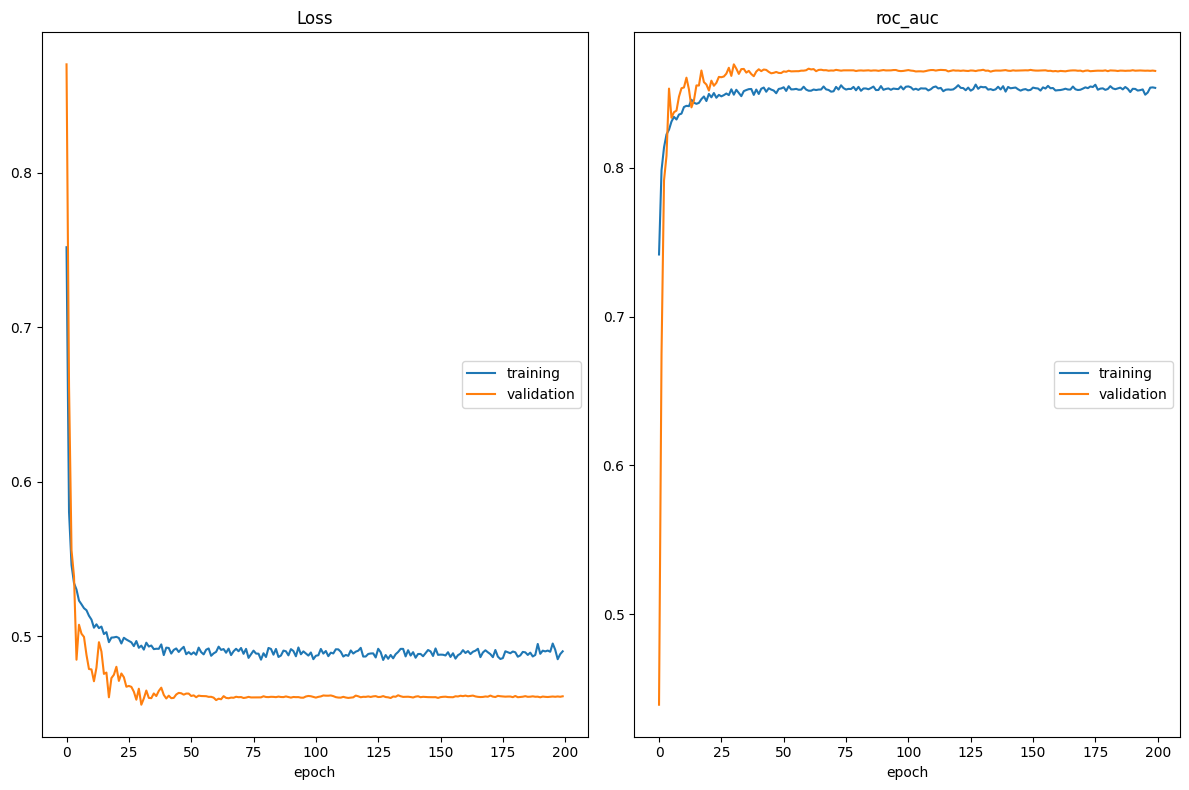

Loss
	training         	 (min:    0.485, max:    0.752, cur:    0.490)
	validation       	 (min:    0.456, max:    0.870, cur:    0.461)
roc_auc
	training         	 (min:    0.742, max:    0.856, cur:    0.854)
	validation       	 (min:    0.439, max:    0.870, cur:    0.865)
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.4977 - roc_auc: 0.8494 - val_loss: 0.4610 - val_roc_auc: 0.8651 - learning_rate: 9.0954e-10
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Test loss: 0.3334246873855591
Test accuracy: 0.0
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Accuracy: 0.7836016473231
Precision: 0.8332704206190334
AUROC: 0.7750315155182412
F1-Score: 0.7982109564687916


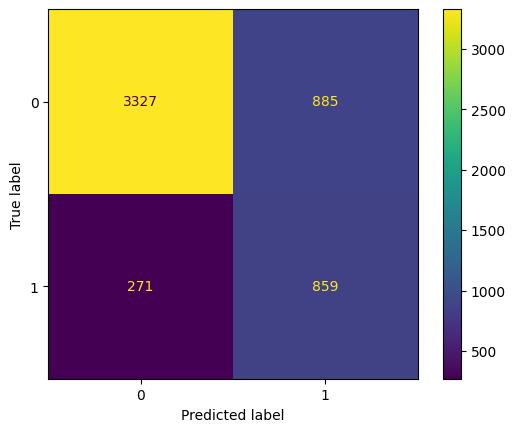

In [24]:
# Callback to plot the loss and auc
plot_losses = livelossplot.PlotLossesKeras() # To plotting
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

# Class weights
class_weights = class_weight.compute_class_weight('balanced', 
                                                classes=np.unique(y_h1n1_train_split), y=y_h1n1_train_split)

# # Aplicar SMOTE para el oversampling en el conjunto de entrenamiento
# smote = SMOTE(random_state=42)
# X_resampled, y_resampled = smote.fit_resample(X_train_split, y_h1n1_train_split)

# # Convertir de nuevo a DataFrame para mantener la estructura
# X_train_split = pd.DataFrame(X_resampled, columns=X_train_split.columns)
# y_h1n1_train_split = pd.Series(y_resampled, name='h1n1_vaccine')
# print(X_train_split.shape, y_h1n1_train_split.shape)

# Create the model for h1n1_vaccine
model = models.Sequential()
model.add(Dense(128, activation='relu', input_shape=(K_FEATURES,)))
model.add(BatchNormalization())
model.add(Dropout(0.4)) #Para neuronas de las capas internas para evitar el overfitting
model.add(Dense(64, activation='elu'))
model.add(Dropout(0.3)) #Para neuronas de las capas internas para evitar el overfitting
model.add(Dense(64, activation='elu'))
model.add(Dropout(0.3)) #Para neuronas de las capas internas para evitar el overfitting
model.add(Dense(32, activation='softplus'))
model.add(Dropout(0.2)) #Para neuronas de las capas internas para evitar el overfitting
model.add(Dense(16, activation='softplus'))
model.add(Dropout(0.2)) #Para neuronas de las capas internas para evitar el overfitting
model.add(Dense(2, activation='softmax')) # The number of outputs is 2

# Compile the model
LEARNING_RATE = 0.001
learning_rate_scheduler = ReduceLROnPlateau(
    monitor='val_roc_auc',
    factor=0.7,
    patience=5,
    verbose=1
)
optimizer = Adam(learning_rate=LEARNING_RATE)
model.compile(optimizer = optimizer,
              loss='binary_crossentropy',
              metrics=[AUC(name='roc_auc')])

BATCH_SIZE = 256 # 256 ejemplos para actualizar los pesos
EPOCHS = 200

# One hot encoding for the target
# Si usas softmax:
y_h1n1_train = to_categorical(y_h1n1_train_split,num_classes=2)
y_h1n1_val = to_categorical(y_h1n1_val_split,num_classes=2)
print('Training:',X_train_split[features_h1n1].shape, y_h1n1_train.shape)
print('Validation:',X_val_split[features_h1n1].shape, y_h1n1_val.shape)
print('Types:',type(X_train_split[features_h1n1]), type(y_h1n1_train))

# Train model
history = model.fit(X_train_split[features_h1n1], y_h1n1_train,
          batch_size=BATCH_SIZE,
          epochs=EPOCHS,
          verbose=1,
          callbacks=[plot_losses,learning_rate_scheduler],
          class_weight={i: weight for i, weight in enumerate(class_weights)},
          validation_data=(X_val_split[features_h1n1], y_h1n1_val))


#Predicción
y_results = model.predict(X_val_split[features_h1n1])

#Evaluacion
score = model.evaluate(X_val_split[features_h1n1], y_results, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])


predictions = model.predict(X_val_split[features_h1n1])
# Si usas softmax:
y_pred_proba = predictions[:,1]
y_pred_classes = predictions.argmax(axis=1)

# Metrics
accuracy = accuracy_score(y_h1n1_val_split, y_pred_classes)
precision = precision_score(y_h1n1_val_split, y_pred_classes, average='weighted')
fpr, tpr, _ = metrics.roc_curve(y_h1n1_val_split, y_pred_classes)
roc_auc = metrics.auc(fpr, tpr)
f1 = f1_score(y_h1n1_val_split, y_pred_classes, average='weighted')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("AUROC:", roc_auc)
print("F1-Score:", f1)

classification_report(y_h1n1_val_split, y_pred_classes)
cm = confusion_matrix(y_h1n1_val_split, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [25]:
# Plot ROC curve
roc_curve(model, y_pred_classes, y_pred_proba, 'DL-h1n1_vaccine')

##### Saving the model in mlflow - h1n1

668/668 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


c:\Users\manup\OneDrive\Escritorio\Git\Task1-ML\ml-lab2\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


835/835 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


Registered model 'neuronal_network_model_h1n1' already exists. Creating a new version of this model...
2024/12/10 18:17:04 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: neuronal_network_model_h1n1, version 46
Created version '46' of model 'neuronal_network_model_h1n1'.


🏃 View run angry-lamb-993 at: http://127.0.0.1:8080/#/experiments/136748955975527113/runs/ad91d1a531484b548436133f177e2eb1
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/136748955975527113


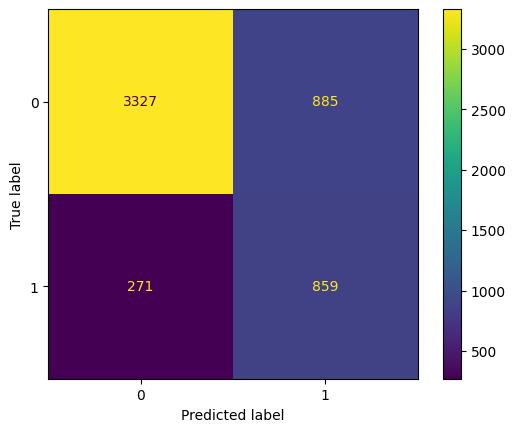

In [27]:
# Save the model in mlflow
# Set our tracking server uri for logging
mlflow.set_tracking_uri(uri="http://127.0.0.1:8080")
# Create a new MLflow Experiment
mlflow.set_experiment("ML-task2-classification-h1n1")
# Start an MLflow run
with mlflow.start_run():
    # Log the hyperparameters
    config = model.get_config()
    for key,item in config.items():
        mlflow.log_param(key, item)

    mlflow.log_param("batch_size", BATCH_SIZE)
    mlflow.log_param("epochs", EPOCHS)
    mlflow.log_param("features", K_FEATURES)
    mlflow.log_param("learning_rate", LEARNING_RATE)
    
    # Log the loss metric
    mlflow.log_metric("accuracy", accuracy)
    mlflow.log_metric("f1_score", f1)
    mlflow.log_metric("precision", precision)
    mlflow.log_metric("roc_auc", roc_auc)

    '''
    for i in range(len(roc_acu)):
        mlflow.log_metric(f"roc_auc_{i}", roc_acu[i])

    mlflow.log_artifact(roc_curve_path.name, "roc_curve")
    '''

    # Confusion matrix
    cm = metrics.confusion_matrix(y_h1n1_val_split, y_pred_classes)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    with tempfile.NamedTemporaryFile("w", suffix=".png", delete=False) as f:
        disp.plot()
        plt.savefig(f.name)
        report_path = f.name  # Guarda la ruta del archivo temporal
    mlflow.log_artifact(report_path, "confusion_matrix")

    # Classification report
    report = classification_report(y_h1n1_val_split, y_pred_classes, zero_division=1)
    with tempfile.NamedTemporaryFile("w", suffix=".txt", delete=False) as f:
        f.write(report)
        report_path = f.name  # Guarda la ruta del archivo temporal
    mlflow.log_artifact(report_path, "classification_report")

    # Set a tag that we can use to remind ourselves what this run was for
    mlflow.set_tag("Training Info", f"Neuronal Network model for h1n1_vaccine")
    # Infer the model signature
    signature = infer_signature(X_train_split[features_h1n1], model.predict(X_train_split[features_h1n1]))
    # Log the model
    model_info = mlflow.sklearn.log_model(
        sk_model=model,
        artifact_path="neuronal_network_model_h1n1", 
        signature=signature,
        input_example=X_train,
        registered_model_name="neuronal_network_model_h1n1",
    )

#### seasonal

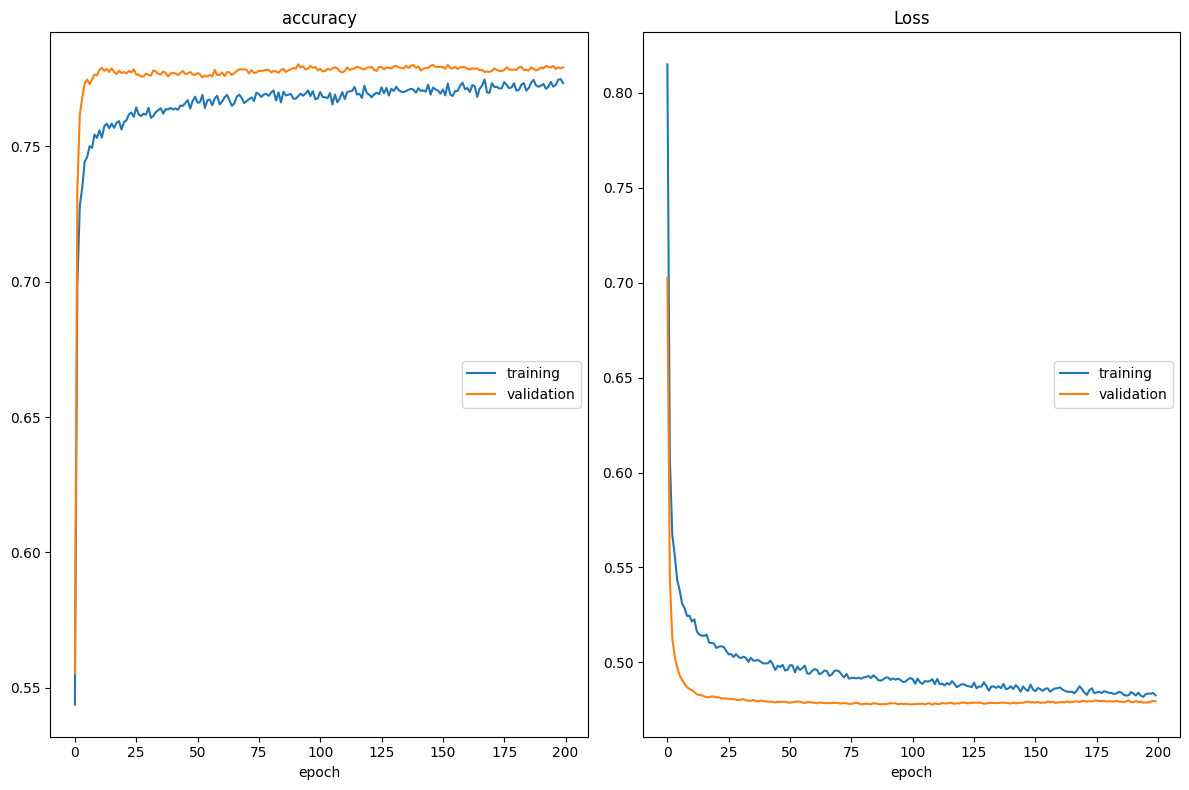

accuracy
	training         	 (min:    0.544, max:    0.775, cur:    0.773)
	validation       	 (min:    0.555, max:    0.780, cur:    0.779)
Loss
	training         	 (min:    0.482, max:    0.815, cur:    0.483)
	validation       	 (min:    0.478, max:    0.703, cur:    0.479)
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7755 - loss: 0.4840 - val_accuracy: 0.7791 - val_loss: 0.4795
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Test loss: 0.3186173141002655
Test accuracy: 1.0
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Accuracy: 0.7791089479595658
Precision: 0.779056576903429
AUROC: 0.6651173637899301
F1-Score: 0.7790810094267278


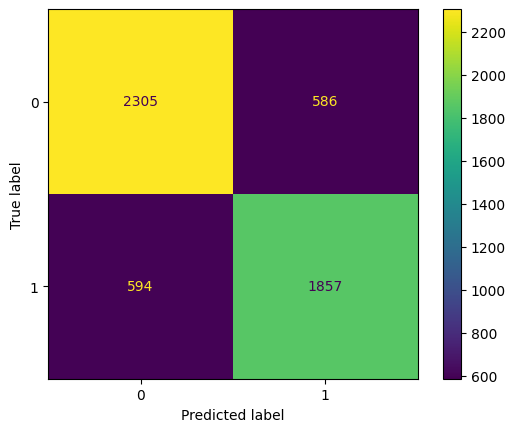

In [28]:
# Callback to plot the loss and auc
plot_losses = livelossplot.PlotLossesKeras() # To plotting
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

# Create the model for h1n1_vaccine
model = models.Sequential()
model.add(Dense(128, activation='relu', input_shape=(K_FEATURES,)))
model.add(BatchNormalization())
model.add(Dropout(0.4)) #Para neuronas de las capas internas para evitar el overfitting
model.add(Dense(64, activation='elu'))
model.add(Dropout(0.2)) #Para neuronas de las capas internas para evitar el overfitting
model.add(Dense(64, activation='elu'))
model.add(Dropout(0.2)) #Para neuronas de las capas internas para evitar el overfitting
model.add(Dense(32, activation='softplus'))
model.add(Dense(2, activation='softmax')) # The number of outputs is 2

# Compile the model
LEARNING_RATE = 7.5e-05
model.compile(optimizer = Adam(learning_rate=LEARNING_RATE),
              loss='binary_crossentropy',
              metrics=['accuracy'])

BATCH_SIZE = 128 # 256 ejemplos para actualizar los pesos
EPOCHS = 200

# One hot encoding for the target
# Si usas softmax:
y_seasonal_train = to_categorical(y_seasonal_train_split,num_classes=2)
y_seasonal_val = to_categorical(y_seasonal_val_split,num_classes=2)

# Train model
history = model.fit(X_train_split[features_seasonal], y_seasonal_train,
          batch_size=BATCH_SIZE,
          epochs=EPOCHS,
          verbose=1,
          callbacks=[plot_losses],
          validation_data=(X_val_split[features_seasonal], y_seasonal_val))


#Predicción
y_results = model.predict(X_val_split[features_seasonal])

#Evaluacion
score = model.evaluate(X_val_split[features_seasonal], y_results, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

predictions = model.predict(X_val_split[features_seasonal])
y_pred_proba = predictions[:,1]
y_pred_classes = predictions.argmax(axis=1)

# Metrics
accuracy = accuracy_score(y_seasonal_val_split, y_pred_classes)
precision = precision_score(y_seasonal_val_split, y_pred_classes, average='weighted')
fpr, tpr, _ = metrics.roc_curve(y_h1n1_val_split, y_pred_classes)
roc_auc = metrics.auc(fpr, tpr)
f1 = f1_score(y_seasonal_val_split, y_pred_classes, average='weighted')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("AUROC:", roc_auc)
print("F1-Score:", f1)

classification_report(y_seasonal_val_split,y_pred_classes)
cm = confusion_matrix(y_seasonal_val_split, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [ ]:
# Plot ROC curve
roc_curve(model,y_pred_classes,y_pred_proba,'DL-seasonal_vaccine')

##### Saving the model in mlflow - seasonal

668/668 ━━━━━━━━━━━━━━━━━━━━ 1s 801us/step


c:\Users\manup\OneDrive\Escritorio\Git\Task1-ML\ml-lab2\lib\site-packages\mlflow\types\utils.py:407: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


835/835 ━━━━━━━━━━━━━━━━━━━━ 1s 919us/step


Registered model 'neuronal_network_model_seasonal' already exists. Creating a new version of this model...
2024/12/07 20:04:52 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: neuronal_network_model_seasonal, version 14
Created version '14' of model 'neuronal_network_model_seasonal'.


🏃 View run bedecked-skunk-106 at: http://127.0.0.1:8080/#/experiments/930371124293830067/runs/82b469ac274f4e8d8a1c3f290a420312
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/930371124293830067


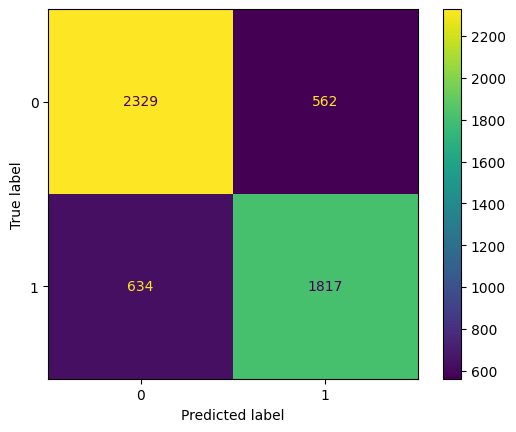

In [ ]:
# Save the model in mlflow
# Set our tracking server uri for logging
mlflow.set_tracking_uri(uri="http://127.0.0.1:8080")
# Create a new MLflow Experiment
mlflow.set_experiment("ML-task2-classification-seasonal")
# Start an MLflow run
with mlflow.start_run():
    # Log the hyperparameters
    config = model.get_config()
    for key,item in config.items():
        mlflow.log_param(key, item)

    mlflow.log_param("batch_size", BATCH_SIZE)
    mlflow.log_param("epochs", EPOCHS)
    mlflow.log_param("features", K_FEATURES)
    mlflow.log_param("learning_rate", LEARNING_RATE)
    
    # Log the loss metric
    mlflow.log_metric("accuracy", accuracy)
    mlflow.log_metric("f1_score", f1)
    mlflow.log_metric("precision", precision)
    mlflow.log_metric("roc_auc", roc_auc)

    # Confusion matrix
    cm = metrics.confusion_matrix(y_seasonal_val_split, y_pred_classes)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    with tempfile.NamedTemporaryFile("w", suffix=".png", delete=False) as f:
        disp.plot()
        plt.savefig(f.name)
        report_path = f.name  # Guarda la ruta del archivo temporal
    mlflow.log_artifact(report_path, "confusion_matrix")

    # Classification report
    report = classification_report(y_seasonal_val_split, y_pred_classes, zero_division=0)
    with tempfile.NamedTemporaryFile("w", suffix=".txt", delete=False) as f:
        f.write(report)
        report_path = f.name  # Guarda la ruta del archivo temporal
    mlflow.log_artifact(report_path, "classification_report")

    # Set a tag that we can use to remind ourselves what this run was for
    mlflow.set_tag("Training Info", f"Neuronal Network model for seasonal_vaccine")
    # Infer the model signature
    signature = infer_signature(X_train_split[features_seasonal], model.predict(X_train_split[features_seasonal]))
    # Log the model
    model_info = mlflow.sklearn.log_model(
        sk_model=model,
        artifact_path="neuronal_network_model_seasonal", 
        signature=signature,
        input_example=X_train,
        registered_model_name="neuronal_network_model_seasonal",
    )

### Bernouilli Naive Bayes

##### h1n1

In [ ]:
# Creating a Bernoulli Naive Bayes model - h1n1_vaccine
SCORING = 'roc_auc'
model = BernoulliNB()
param_grid = {'alpha': np.linspace(0.1, 10, 20),
              'binarize': np.linspace(0.0, 10, 20),
              'fit_prior': [True, False]}

# alpha is for smoothing and binarize is for thresholding

# Set up the GridSearchCV with cross-validation and mean squared error as the scoring metric
grid_search = GridSearchCV(estimator=model,
                        param_grid=param_grid,
                        cv=CV,
                        scoring=SCORING,
                        n_jobs=1, 
                        verbose=1)

# Train the model
grid_search.fit(X_train_split[features_h1n1], y_h1n1_train_split)

# See the best features
print(grid_search.best_params_)

# predict
y_pred = grid_search.predict(X_val_split[features_h1n1])
y_pred_proba = grid_search.predict_proba(X_val_split[features_h1n1])[:,1]

# Evaluate the model
accuracy = accuracy_score(y_h1n1_val_split, y_pred)
f1_score_ = f1_score(y_h1n1_val_split, y_pred, average='weighted',zero_division=0)
precision = precision_score(y_h1n1_val_split, y_pred, average='weighted',zero_division=0)
fpr, tpr, _ = metrics.roc_curve(y_h1n1_val_split, y_pred_classes)
roc_auc = metrics.auc(fpr, tpr)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("F1-Score:", f1_score_)
print("AUROC:", roc_auc)

Fitting 5 folds for each of 800 candidates, totalling 4000 fits
{'alpha': np.float64(0.1), 'binarize': np.float64(0.0), 'fit_prior': True}
Accuracy: 0.7968925496068888
Precision: 0.7826447470302738
F1-Score: 0.7879524132653131
AUROC: 0.6556421181789913


In [ ]:
# Plot ROC curve
roc_curve(grid_search, y_pred, y_pred_proba, 'NB-h1n1_vaccine')

#### Saving the model in mlflow - h1n1

Registered model 'bernoulli_naive_bayes_model_h1n1' already exists. Creating a new version of this model...
2024/12/07 13:36:20 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: bernoulli_naive_bayes_model_h1n1, version 16


🏃 View run sassy-auk-33 at: http://127.0.0.1:8080/#/experiments/136748955975527113/runs/e40323cd83ec4b199726deecc97330f7
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/136748955975527113


Created version '16' of model 'bernoulli_naive_bayes_model_h1n1'.


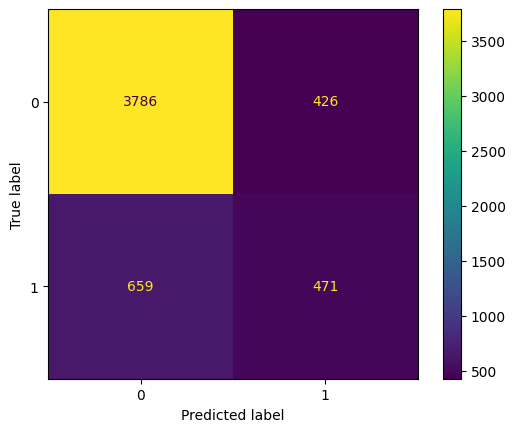

In [ ]:
# Save the model in mlflow
# Set our tracking server uri for logging
mlflow.set_tracking_uri(uri="http://127.0.0.1:8080")
# Create a new MLflow Experiment
mlflow.set_experiment("ML-task2-classification-h1n1")
# Start an MLflow run
with mlflow.start_run():
    # Log the hyperparameters
    mlflow.log_params(grid_search.best_params_)
    # Log the loss metric
    mlflow.log_metric("accuracy", accuracy)
    mlflow.log_metric("f1_score", f1_score_)
    mlflow.log_metric("precision", precision)
    mlflow.log_metric("roc_auc", roc_auc)
    mlflow.log_metric("cross_validation", CV)
    mlflow.log_metric("k_features",K_FEATURES)
    
    # Confusion matrix
    cm = metrics.confusion_matrix(y_h1n1_val_split, y_pred)
    disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=grid_search.classes_)
    with tempfile.NamedTemporaryFile("w", suffix=".png", delete=False) as f:
        disp.plot()
        plt.savefig(f.name)
        report_path = f.name  # Guarda la ruta del archivo temporal
    mlflow.log_artifact(report_path, "confusion_matrix")

    # Classification report
    report = classification_report(y_h1n1_val_split, y_pred, zero_division=1)
    with tempfile.NamedTemporaryFile("w", suffix=".txt", delete=False) as f:
        f.write(report)
        report_path = f.name  # Guarda la ruta del archivo temporal
    mlflow.log_artifact(report_path, "classification_report")

    # Set a tag that we can use to remind ourselves what this run was for
    mlflow.set_tag("Training Info", f"Bernouilli Naive Bayes model for h1n1_vaccine")
    # Infer the model signature
    signature = infer_signature(X_train_split[features_h1n1], grid_search.predict(X_train_split[features_h1n1]))
    # Log the model
    model_info = mlflow.sklearn.log_model(
        sk_model=grid_search,
        artifact_path="bernoulli_naive_bayes_model_h1n1", 
        signature=signature,
        input_example=X_train,
        registered_model_name="bernoulli_naive_bayes_model_h1n1",
    )

#### seasonal

In [ ]:
SCORING = 'roc_auc'
# Creating a Bernoulli Naive Bayes model - seasonal_vaccine
model = BernoulliNB()
param_grid = {'alpha': np.linspace(0.1, 10, 20),
              'binarize': np.linspace(0.0, 10, 20),
              'fit_prior': [True, False]}

# Set up the GridSearchCV with cross-validation and mean squared error as the scoring metric
grid_search = GridSearchCV(estimator=model,
                        param_grid=param_grid,
                        cv=CV,
                        scoring=SCORING,
                        n_jobs=1, 
                        verbose=1)

# Train the model
grid_search.fit(X_train_split[features_seasonal], y_seasonal_train_split)
# See the best features
print(grid_search.best_params_)

# predict
y_pred = grid_search.predict(X_val_split[features_seasonal])
y_pred_proba = grid_search.predict_proba(X_val_split[features_seasonal])[:,1]
# Metrics
accuracy = accuracy_score(y_seasonal_val_split, y_pred)
f1_score_ = f1_score(y_seasonal_val_split, y_pred, average='weighted',zero_division=0)
precision = precision_score(y_seasonal_val_split, y_pred, average='weighted',zero_division=0)
fpr, tpr, _ = metrics.roc_curve(y_h1n1_val_split, y_pred_classes)
roc_auc = metrics.auc(fpr, tpr)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("AUROC:", roc_auc)
print("F1-Score:", f1_score_)


Fitting 5 folds for each of 800 candidates, totalling 4000 fits
{'alpha': np.float64(9.478947368421053), 'binarize': np.float64(2.1052631578947367), 'fit_prior': True}
Accuracy: 0.6943092474728566
Precision: 0.6936775593082866
AUROC: 0.6556421181789913
F1-Score: 0.6937999165576135


In [ ]:
# Plot ROC curve
roc_curve(grid_search, y_pred, y_pred_proba, 'BernoulliNB-seasonal_vaccine')

#### Saving the model in mlflow - seasonal

Registered model 'bernoulli_naive_bayes_model_seasonal' already exists. Creating a new version of this model...
2024/12/07 13:37:09 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: bernoulli_naive_bayes_model_seasonal, version 13


🏃 View run popular-squid-459 at: http://127.0.0.1:8080/#/experiments/930371124293830067/runs/500ec4d173a04d098a52330296449247
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/930371124293830067


Created version '13' of model 'bernoulli_naive_bayes_model_seasonal'.


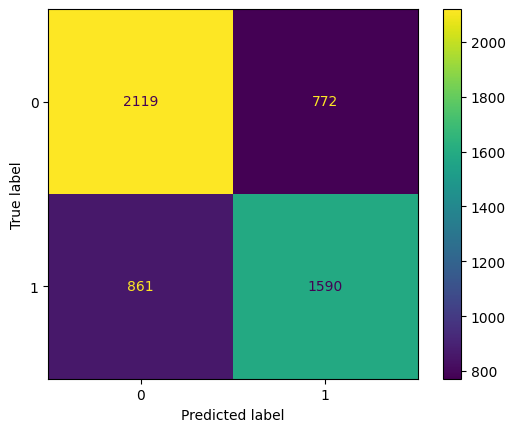

In [ ]:
# Save the model in mlflow
# Set our tracking server uri for logging
mlflow.set_tracking_uri(uri="http://127.0.0.1:8080")
# Create a new MLflow Experiment
mlflow.set_experiment("ML-task2-classification-seasonal")
# Start an MLflow run
with mlflow.start_run():
    # Log the hyperparameters
    mlflow.log_params(grid_search.best_params_)
    # Log the loss metric
    mlflow.log_metric("accuracy", accuracy)
    mlflow.log_metric("f1_score", f1_score_)
    mlflow.log_metric("precision", precision)
    mlflow.log_metric("roc_auc", roc_auc)
    mlflow.log_metric("cross_validation", CV)
    mlflow.log_metric("k_features", K_FEATURES)
        
    # Confusion matrix
    cm = metrics.confusion_matrix(y_seasonal_val_split, y_pred)
    disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=grid_search.classes_)
    with tempfile.NamedTemporaryFile("w", suffix=".png", delete=False) as f:
        disp.plot()
        plt.savefig(f.name)
        report_path = f.name  # Guarda la ruta del archivo temporal
    mlflow.log_artifact(report_path, "confusion_matrix")

    # Classification report
    report = classification_report(y_h1n1_val_split, y_pred, zero_division=1)
    with tempfile.NamedTemporaryFile("w", suffix=".txt", delete=False) as f:
        f.write(report)
        report_path = f.name  # Guarda la ruta del archivo temporal
    mlflow.log_artifact(report_path, "classification_report")

    # Set a tag that we can use to remind ourselves what this run was for
    mlflow.set_tag("Training Info", f"Bernouilli Naive Bayes model for seasonal_vaccine")
    # Infer the model signature
    signature = infer_signature(X_train_split[features_seasonal], grid_search.predict(X_train_split[features_seasonal]))
    # Log the model
    model_info = mlflow.sklearn.log_model(
        sk_model=grid_search,
        artifact_path="bernoulli_naive_bayes_model_seasonal", 
        signature=signature,
        input_example=X_train,
        registered_model_name="bernoulli_naive_bayes_model_seasonal",
    )

## Class Approach: Undersampling

### Neural Network

#### h1n1

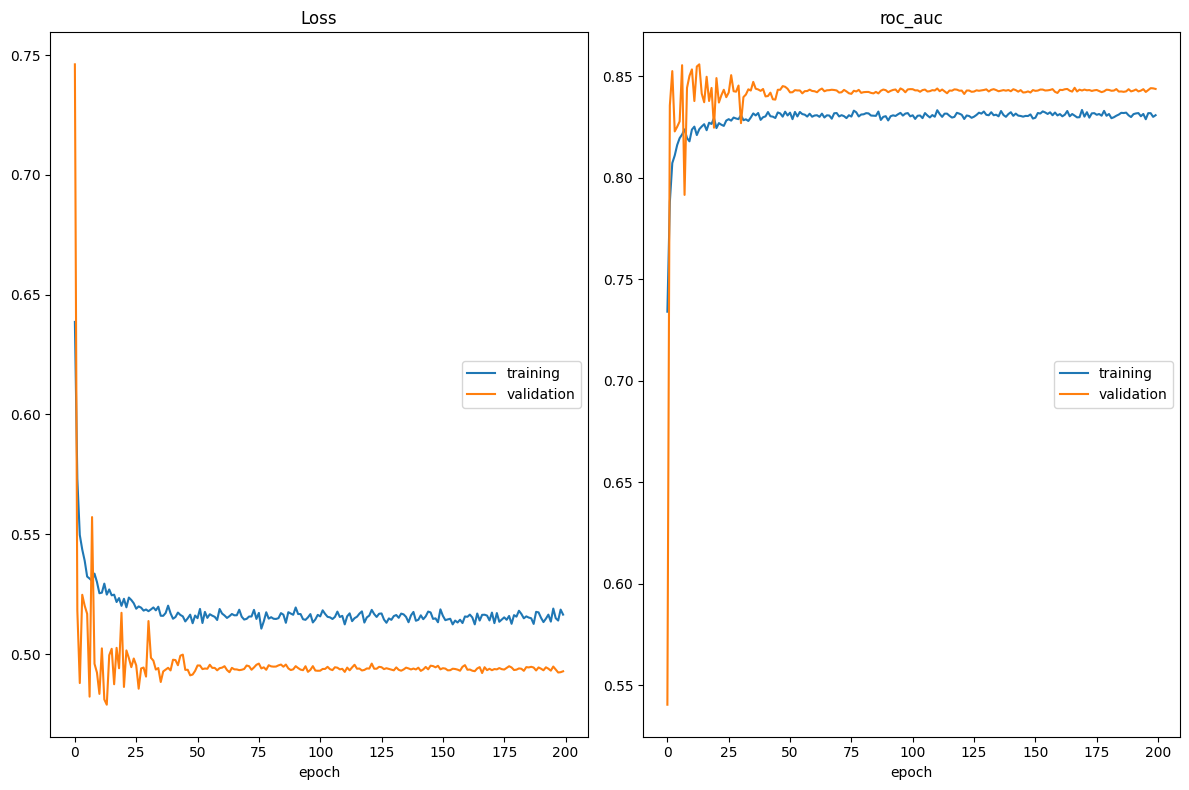

Loss
	training         	 (min:    0.511, max:    0.639, cur:    0.516)
	validation       	 (min:    0.479, max:    0.746, cur:    0.493)
roc_auc
	training         	 (min:    0.734, max:    0.833, cur:    0.831)
	validation       	 (min:    0.540, max:    0.856, cur:    0.844)
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.5134 - roc_auc: 0.8311 - val_loss: 0.4928 - val_roc_auc: 0.8437 - learning_rate: 9.0954e-10
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Test loss: 0.38255608081817627
Test accuracy: 0.0
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 926us/step
Accuracy: 0.7701235492324972
Precision: 0.822339389275886
AUROC: 0.7570951936733648
F1-Score: 0.7858582926691488


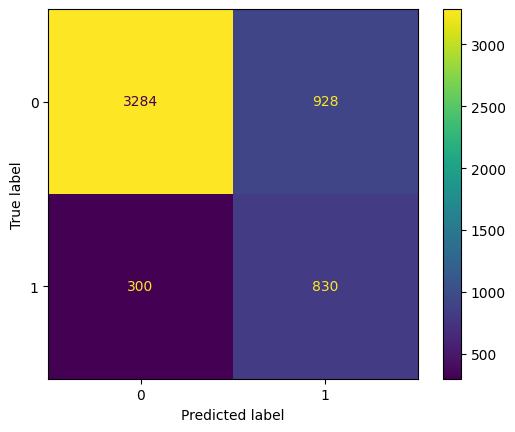

In [ ]:
# Callback to plot the loss and auc
plot_losses = livelossplot.PlotLossesKeras() # To plotting
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

# Class weights
# class_weights = class_weight.compute_class_weight('balanced', 
#                                                 classes=np.unique(y_h1n1_train_split), y=y_h1n1_train_split)

# DEALING WITH IMBALANCED DATASET
# 1. Identificar las clases y la clase mayoritaria y minoritaria
unique, counts = np.unique(y_h1n1_train_split, return_counts=True)
print('Distribución de clases antes del undersampling:', dict(zip(unique, counts)))

# Determinar cuál es la clase mayoritaria y minoritaria
majority_class = unique[np.argmax(counts)]
minority_class = unique[np.argmin(counts)]

# 2. Separar las instancias de cada clase
majority_samples = X_train_split[y_h1n1_train_split == majority_class]
majority_labels = y_h1n1_train_split[y_h1n1_train_split == majority_class]

minority_samples = X_train_split[y_h1n1_train_split == minority_class]
minority_labels = y_h1n1_train_split[y_h1n1_train_split == minority_class]

# 3. Hacer undersampling (reducir la clase mayoritaria)
# Reducir el número de muestras de la clase mayoritaria al tamaño de la clase minoritaria
majority_samples_resampled, majority_labels_resampled = resample(majority_samples, majority_labels,
                                                                replace=False,
                                                                n_samples=len(minority_samples),
                                                                random_state=42)

# 4. Concatenar las muestras de la clase minoritaria con las muestras re-muestreadas de la clase mayoritaria
X_train_undersampled = pd.concat([minority_samples, majority_samples_resampled], axis=0, ignore_index=True)
y_train_undersampled = np.concatenate([minority_labels, majority_labels_resampled], axis=0)

# 5. Verificar la distribución después del undersampling
unique, counts = np.unique(y_train_undersampled, return_counts=True)
print('Distribución de clases después del undersampling:', dict(zip(unique, counts)))
sleep(5)

# Create the model for h1n1_vaccine
model = models.Sequential()
model.add(Dense(128, activation='relu', input_shape=(K_FEATURES,)))
model.add(BatchNormalization())
model.add(Dropout(0.4)) #Para neuronas de las capas internas para evitar el overfitting
model.add(Dense(64, activation='elu'))
model.add(Dropout(0.3)) #Para neuronas de las capas internas para evitar el overfitting
model.add(Dense(32, activation='softplus'))
model.add(Dropout(0.2)) #Para neuronas de las capas internas para evitar el overfitting
model.add(Dense(16, activation='softplus'))
model.add(Dropout(0.2)) #Para neuronas de las capas internas para evitar el overfitting
model.add(Dense(2, activation='softmax')) # The number of outputs is 2

# Compile the model
LEARNING_RATE = 0.001
learning_rate_scheduler = ReduceLROnPlateau(
    monitor='val_roc_auc',
    factor=0.7,
    patience=5,
    verbose=1
)
optimizer = Adam(learning_rate=LEARNING_RATE)
model.compile(optimizer = optimizer,
              loss='binary_crossentropy',
              metrics=[AUC(name='roc_auc')])

BATCH_SIZE = 128 # 256 ejemplos para actualizar los pesos
EPOCHS = 200

# One hot encoding for the target
# Si usas softmax:
y_h1n1_train = to_categorical(y_h1n1_train_split,num_classes=2)
y_h1n1_val = to_categorical(y_h1n1_val_split,num_classes=2)
#print('Training:',X_train_split[features_h1n1].shape, y_h1n1_train.shape)
#print('Validation:',X_val_split[features_h1n1].shape, y_h1n1_val.shape)

unique, counts = np.unique(y_h1n1_train_split, return_counts=True)
print('Distribution of classes (y):', dict(zip(unique, counts)))


# Train model
history = model.fit(X_train_split[features_h1n1], y_h1n1_train,
          batch_size=BATCH_SIZE,
          epochs=EPOCHS,
          verbose=1,
          callbacks=[plot_losses,learning_rate_scheduler],
          class_weight={i: weight for i, weight in enumerate(class_weights)},
          validation_data=(X_val_split[features_h1n1], y_h1n1_val))


#Predicción
y_results = model.predict(X_val_split[features_h1n1])

#Evaluacion
score = model.evaluate(X_val_split[features_h1n1], y_results, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])


predictions = model.predict(X_val_split[features_h1n1])
# Si usas softmax:
y_pred_proba = predictions[:,1]
y_pred_classes = predictions.argmax(axis=1)

# Metrics
accuracy = accuracy_score(y_h1n1_val_split, y_pred_classes)
precision = precision_score(y_h1n1_val_split, y_pred_classes, average='weighted')
fpr, tpr, _ = metrics.roc_curve(y_h1n1_val_split, y_pred_classes)
roc_auc = metrics.auc(fpr, tpr)
f1 = f1_score(y_h1n1_val_split, y_pred_classes, average='weighted')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("AUROC:", roc_auc)
print("F1-Score:", f1)

classification_report(y_h1n1_val_split, y_pred_classes)
cm = confusion_matrix(y_h1n1_val_split, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [ ]:
# Plot ROC curve
roc_curve(model, y_pred_classes, y_pred_proba, 'DL-h1n1_vaccine')

##### Saving the model in mlflow - h1n1

668/668 ━━━━━━━━━━━━━━━━━━━━ 1s 862us/step


835/835 ━━━━━━━━━━━━━━━━━━━━ 1s 850us/step


Registered model 'neuronal_network_model_h1n1' already exists. Creating a new version of this model...
2024/12/08 13:25:46 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: neuronal_network_model_h1n1, version 45


🏃 View run casual-mare-471 at: http://127.0.0.1:8080/#/experiments/136748955975527113/runs/b8b5f72712664358a9d63dd070f006bb
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/136748955975527113


Created version '45' of model 'neuronal_network_model_h1n1'.


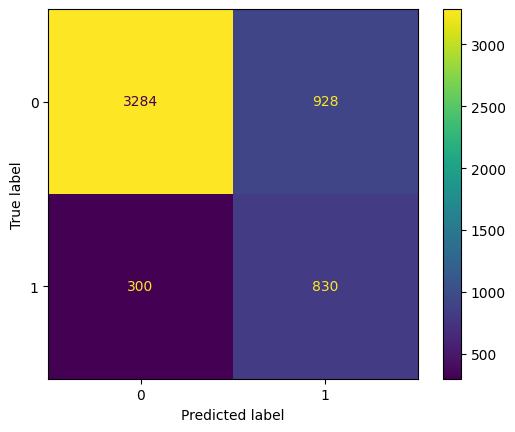

In [ ]:
# Save the model in mlflow
# Set our tracking server uri for logging
mlflow.set_tracking_uri(uri="http://127.0.0.1:8080")
# Create a new MLflow Experiment
mlflow.set_experiment("ML-task2-classification-h1n1")
# Start an MLflow run
with mlflow.start_run():
    # Log the hyperparameters
    config = model.get_config()
    for key,item in config.items():
        mlflow.log_param(key, item)

    mlflow.log_param("batch_size", BATCH_SIZE)
    mlflow.log_param("epochs", EPOCHS)
    mlflow.log_param("features", K_FEATURES)
    mlflow.log_param("learning_rate", LEARNING_RATE)
    
    # Log the loss metric
    mlflow.log_metric("accuracy", accuracy)
    mlflow.log_metric("f1_score", f1)
    mlflow.log_metric("precision", precision)
    mlflow.log_metric("roc_auc", roc_auc)

    '''
    for i in range(len(roc_acu)):
        mlflow.log_metric(f"roc_auc_{i}", roc_acu[i])

    mlflow.log_artifact(roc_curve_path.name, "roc_curve")
    '''

    # Confusion matrix
    cm = metrics.confusion_matrix(y_h1n1_val_split, y_pred_classes)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    with tempfile.NamedTemporaryFile("w", suffix=".png", delete=False) as f:
        disp.plot()
        plt.savefig(f.name)
        report_path = f.name  # Guarda la ruta del archivo temporal
    mlflow.log_artifact(report_path, "confusion_matrix")

    # Classification report
    report = classification_report(y_h1n1_val_split, y_pred_classes, zero_division=1)
    with tempfile.NamedTemporaryFile("w", suffix=".txt", delete=False) as f:
        f.write(report)
        report_path = f.name  # Guarda la ruta del archivo temporal
    mlflow.log_artifact(report_path, "classification_report")

    # Set a tag that we can use to remind ourselves what this run was for
    mlflow.set_tag("Training Info", f"Neuronal Network model for h1n1_vaccine")
    # Infer the model signature
    signature = infer_signature(X_train_split[features_h1n1], model.predict(X_train_split[features_h1n1]))
    # Log the model
    model_info = mlflow.sklearn.log_model(
        sk_model=model,
        artifact_path="neuronal_network_model_h1n1", 
        signature=signature,
        input_example=X_train,
        registered_model_name="neuronal_network_model_h1n1",
    )

### Bernouilli Naive Bayes